In [1]:
## Standard Stuff
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import dask.array as da
import numcodecs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake     # For catalogs
import zarr       

from dask.diagnostics import ProgressBar
import seaborn as sns

from scipy import stats
import datetime

import healpix_utils

import matplotlib.patheffects as PathEffects



In [2]:
# I like serif fonts
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams["mathtext.fontset"] = 'stix'
plt.rcParams['text.usetex'] = False
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.rcParams['figure.dpi'] = 70 # change for figure quality

In [5]:
# Get the plasma colormap
cmap = plt.get_cmap('plasma')
# Get the corresponding colors
colors = [cmap(v) for v in np.linspace(0, 1, 10)]

In [6]:
colors_reverse = colors[::-1]
colors = colors + colors_reverse[1:]


In [47]:
def return_ax(hist_data, ax):
    # Define temperature bin edges and centers
    temp_bin_edges = np.arange(200, 270)  # 200 to 270 inclusive
    temp_bin_centers = (temp_bin_edges[:-1] + temp_bin_edges[1:]) / 2  # 70 centers
    
    # Sort latitude bins by their lower bound for consistent stacking
    sorted_lat_bins = sorted(hist_data.keys(), key=lambda x: x)
    stack_data = [hist_data[lat_bin][0] for lat_bin in sorted_lat_bins]

    x, y = np.zeros(len(sorted_lat_bins)), np.zeros(len(sorted_lat_bins))
    
    # Plot first layer
    ax.bar(
        temp_bin_centers,
        stack_data[0],
        width=1.0,
        color = colors[0],
        alpha = 0.8
    )

    x[0] = np.sum(temp_bin_centers * stack_data[0])/np.sum(stack_data[0])
    y[0] = np.max(stack_data[0])
    
    # Plot the rest of the stacked bars
    bottom = stack_data[0].copy()
    for i in range(1, len(stack_data)):

        ax.bar(
            temp_bin_centers,
            stack_data[i],
            width=1.0,
            bottom=bottom,
            color = colors[i],
            alpha = 0.8
        )
        bottom += stack_data[i]
        
        x[i] = np.sum(temp_bin_centers * stack_data[i])/np.sum(stack_data[i])
        y[i] = np.max(bottom)


    
    sns.despine()
    
    return ax, x, y


In [8]:
## XSHIELD 2024
hist_data_x24 = np.load('hist_data_xshield24.npy', allow_pickle = True).tolist()
cloudy_composite_x24 = xr.open_dataset('../hk25-CloudClimato/xshield24_composite.nc')

## ICON
hist_data_icon = np.load('/home/pc6491/hk25-teams/hk25-HighCloudT/hist_data_ICONd3hp003.npy', allow_pickle = True).tolist()
cloudy_composite_icon = xr.open_dataset('../hk25-CloudClimato/ICONd3hp003_composite.nc')

## IFS
hist_data_ifs = np.load('/home/pc6491/hk25-teams/hk25-HighCloudT/hist_data_IFS.npy', allow_pickle = True).tolist()
cloudy_composite_ifs = xr.open_dataset('../hk25-CloudClimato/IFS_composite.nc')

## UM
hist_data_um = np.load('/home/pc6491/hk25-teams/hk25-HighCloudT/hist_data_um_glm_n1280_CoMA9_TBv1p2.npy', allow_pickle = True).tolist()
cloudy_composite_um = xr.open_dataset('../hk25-CloudClimato/um_glm_n1280_CoMA9_TBv1p2_composite.nc')


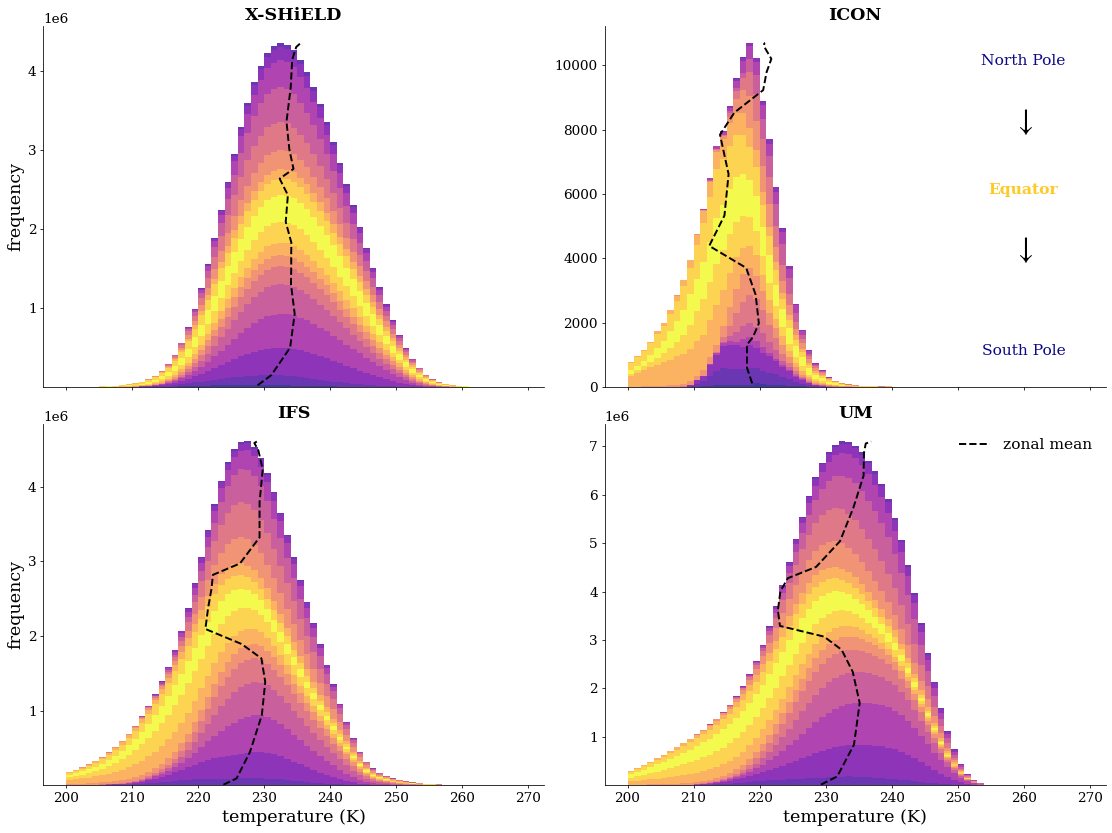

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Create the plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0], meanx_xshield24, meany_xshield24 = return_ax(hist_data_x24, axes[0, 0])
axes[0, 1], meanx_icon, meany_icon = return_ax(hist_data_icon, axes[0, 1])
axes[1, 0], meanx_ifs, meany_ifs = return_ax(hist_data_ifs, axes[1, 0])
axes[1, 1], meanx_um, meany_um = return_ax(hist_data_um, axes[1, 1])

# Add labels, legend, and formatting
axes[1, 0].set_xlabel("temperature (K)")
axes[1, 1].set_xlabel("temperature (K)")

axes[0, 0].set_ylabel("frequency")
axes[1, 0].set_ylabel("frequency")

axes[0, 1].text(260, 1e4, 'North Pole', color = colors[0], fontsize = 16, ha = 'center')
axes[0, 1].text(260, 8e3, '$\\downarrow$', color = 'black', fontsize = 32, ha = 'center')
axes[0, 1].text(260, 6e3, 'Equator', color = colors[8], fontsize = 16, ha = 'center', fontweight = 'bold')
axes[0, 1].text(260, 4e3, '$\\downarrow$', color = 'black', fontsize = 32, ha = 'center')
axes[0, 1].text(260, 1e3, 'South Pole', color = colors[0], fontsize = 16, ha = 'center')

axes[0, 0].set_xticklabels([])
axes[0, 1].set_xticklabels([])

axes[0, 0].set_title('X-SHiELD', fontweight = 'bold')
axes[0, 1].set_title('ICON', fontweight = 'bold')
axes[1, 0].set_title('IFS', fontweight = 'bold')
axes[1, 1].set_title('UM', fontweight = 'bold')

#axes[0, 0].set_ylim([0, 7.5e6])

axes[0, 0].plot(meanx_xshield24, meany_xshield24, linewidth = 2, linestyle = 'dashed', color = 'black')
axes[0, 1].plot(meanx_icon, meany_icon, linewidth = 2, linestyle = 'dashed', color = 'black')
axes[1, 0].plot(meanx_ifs, meany_ifs, linewidth = 2, linestyle = 'dashed', color = 'black')
axes[1, 1].plot(meanx_um, meany_um, linewidth = 2, linestyle = 'dashed', color = 'black', label = 'zonal mean')

axes[1, 1].legend(frameon = False)
plt.tight_layout()
plt.savefig('stacked_hist.png', dpi = 600)
plt.show()
